## Probabilistic Forecast
**Predicciones con intervalos. Entendimiento notebook template SKFORECAST**

**Source**: https://skforecast.org/0.13.0/user_guides/probabilistic-forecasting

Al intentar anticipar valores futuros, la mayoría de los modelos de pronóstico intentan predecir cuál será el valor más probable. Esto se denomina pronóstico puntual. Aunque conocer de antemano el valor esperado de una serie temporal es útil en casi todos los casos comerciales, este tipo de predicción no proporciona ninguna información sobre la confianza del modelo ni la incertidumbre de la predicción.

El pronóstico probabilístico, a diferencia del pronóstico puntual, es una familia de técnicas que permiten predecir la distribución esperada del resultado en lugar de un único valor futuro. Este tipo de pronóstico proporciona mucha información valiosa, ya que permite crear intervalos de predicción, el rango de valores probables en los que puede caer el valor verdadero. Más formalmente, un intervalo de predicción define el intervalo dentro del cual se espera que se encuentre el valor verdadero de la variable de respuesta con una probabilidad dada.

**Hay múltiples formas de estimar intervalos de predicción, la mayoría de las cuales requieren que los residuos (errores) del modelo sigan una distribución normal. Cuando no se puede asumir esta propiedad, dos alternativas que se utilizan comúnmente son el bootstrap y la regresión cuantílica.** 

Para ilustrar cómo skforecast permite estimar intervalos de predicción para pronósticos de varios pasos, se muestran los siguientes ejemplos:

- **Intervalos de predicción basados ​​en residuos de bootstrap y pronosticador recursivo de varios pasos.**
- **Intervalos de predicción basados ​​en regresión cuantil y pronosticador directo de varios pasos.**

Todos los pronosticadores en skforecast tienen cuatro métodos diferentes que permiten pronósticos probabilísticos:

- predict_bootstrapping: este método genera múltiples predicciones de pronóstico a través de un proceso de bootstrap. Al tomar muestras de una colección de errores observados en el pasado (los residuos), cada iteración de bootstrap genera un conjunto diferente de predicciones. El resultado es un DataFrame de pandas con una fila para cada paso predicho y una columna para cada iteración de bootstrap.
  
- predict_intervals: este método estima intervalos de predicción cuantil utilizando los valores generados con predict_bootstrapping.

- predict_quantiles: este método estima una lista de predicciones cuantiles utilizando los valores generados con predict_bootstrapping.

- predict_dist: este método ajusta una distribución paramétrica utilizando los valores generados con predict_bootstrapping. Se puede utilizar cualquiera de las distribuciones continuas disponibles en scipy.stats.
  
Las cuatro pueden utilizar residuos dentro de la muestra (predeterminado) o residuos fuera de la muestra. En ambos casos, los residuos se pueden condicionar al valor predicho para intentar dar cuenta de la existencia de una correlación entre los valores predichos y los residuos.

WARNING:

As Rob J Hyndman explains in his blog, in real-world problems, almost all prediction intervals are too narrow. For example, nominal 95% intervals may only provide coverage between 71% and 87%. This is a well-known phenomenon and arises because they do not account for all sources of uncertainty. With forecasting models, there are at least four sources of uncertainty:

The random error term
The parameter estimates
The choice of model for the historical data
The continuation of the historical data generating process into the future
When producing prediction intervals for time series models, generally only the first of these sources is taken into account. Therefore, it is advisable to use test data to validate the empirical coverage of the interval and not solely rely on the expected coverage.

https://robjhyndman.com/hyndsight/narrow-pi/

NOTE:
Conformal prediction is a relatively new framework that allows for the creation of confidence measures for predictions made by machine learning models. This method is on the roadmap of skforecast, but not yet available.

#### importante: se en sklearn y en nixtla se hace de forma distinta para obtener predicciones probabilisticas
- nixtla: conformal prediction
- skforecast: bootstrap y regresion quantil

### 1. Prediction intervals using bootstrapped residuals
The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from pprint import pprint
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from scipy.stats import norm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_pinball_loss
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing_extended_features')
data.head(2)

bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


,users,weather,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,...,8.063334,10.127976,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,...,8.029166,10.113334,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0


In [4]:
# One hot encoding of categorical variables
# ==============================================================================
encoder = ColumnTransformer(
              [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['weather'])],
              remainder='passthrough',
              verbose_feature_names_out=False
          ).set_output(transform="pandas")
data = encoder.fit_transform(data)
data.head()

,weather_clear,weather_mist,weather_rain,users,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,0.0,1.0,0.0,25.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,...,8.063334,10.127976,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,0.0,1.0,0.0,16.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,...,8.029166,10.113334,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 02:00:00,0.0,1.0,0.0,16.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,...,7.995000,10.103572,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 03:00:00,0.0,0.0,1.0,7.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,...,7.960833,10.093809,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 04:00:00,0.0,0.0,1.0,1.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,...,7.926667,10.079166,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0


In [5]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = [
    'weather_clear', 'weather_mist', 'weather_rain', 'month_sin', 'month_cos',
    'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos',
    'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'temp', 'holiday'
]
data = data[['users'] + exog_features]
data.head()

,users,weather_clear,weather_mist,weather_rain,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,sunrise_hour_sin,sunrise_hour_cos,sunset_hour_sin,sunset_hour_cos,temp,holiday
date_time,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,0.0,1.0,0.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,0.965926,-0.258819,-0.866025,-0.5,7.38,0.0
2011-01-08 01:00:00,16.0,0.0,1.0,0.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,0.965926,-0.258819,-0.866025,-0.5,7.38,0.0
2011-01-08 02:00:00,16.0,0.0,1.0,0.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.707107,0.707107,0.965926,-0.258819,-0.866025,-0.5,7.38,0.0
2011-01-08 03:00:00,7.0,0.0,0.0,1.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.866025,0.500000,0.965926,-0.258819,-0.866025,-0.5,7.38,0.0
2011-01-08 04:00:00,1.0,0.0,0.0,1.0,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.965926,0.258819,0.965926,-0.258819,-0.866025,-0.5,7.38,0.0


In [6]:
# Split train-validation-test
# ==============================================================================
data = data.loc['2011-05-30 23:59:00':, :]
end_train = '2012-08-30 23:59:00'
end_validation = '2012-11-15 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-05-31 00:00:00 --- 2012-08-30 23:00:00  (n=10992)
Dates validacion : 2012-08-31 00:00:00 --- 2012-11-15 23:00:00  (n=1848)
Dates test       : 2012-11-16 00:00:00 --- 2012-12-30 23:00:00  (n=1080)


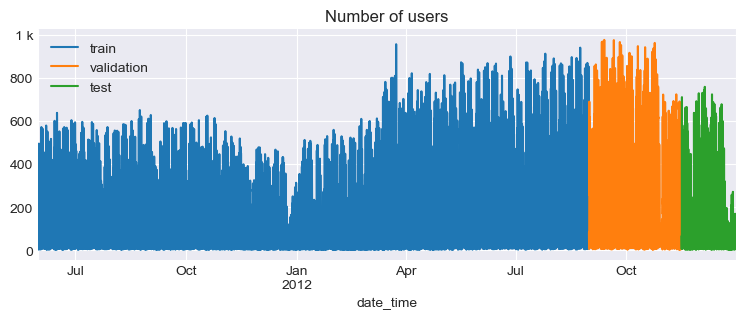

In [7]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3))
data_train['users'].plot(label='train', ax=ax)
data_val['users'].plot(label='validation', ax=ax)
data_test['users'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title('Number of users')
ax.legend();

#### Intervals with In-sample residuals

By default, intervals can be computed using in-sample residuals (residuals from the training set), either by calling the predict_interval() method, or by performing a full backtesting procedure.

However, this can result in intervals that are too narrow (overly optimistic).

In [8]:
# Create and fit forecaster
# ==============================================================================
params = {
    "n_estimators": 600,
    "max_depth": 6,
    "min_data_in_leaf": 88,
    "learning_rate": 0.2520098236227423,
    "feature_fraction": 0.6,
    "max_bin": 75,
    "reg_alpha": 1.0,
    "reg_lambda": 0.8,
}
lags = 48

forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags      = lags
             )
forecaster.fit(
    y    = data.loc[:end_validation, 'users'],
    exog = data.loc[:end_validation, exog_features]
)

In [9]:
# In-sample residuals stored during fit
# ==============================================================================
print("Amount of residuals stored:", len(forecaster.in_sample_residuals))
forecaster.in_sample_residuals

Amount of residuals stored: 2000


array([ -2.20887533,  -5.90417032,   1.3012363 , ..., -18.71892632,
        26.46825175,   0.18927409])

## terminar de revisar ejemplos de skforecast